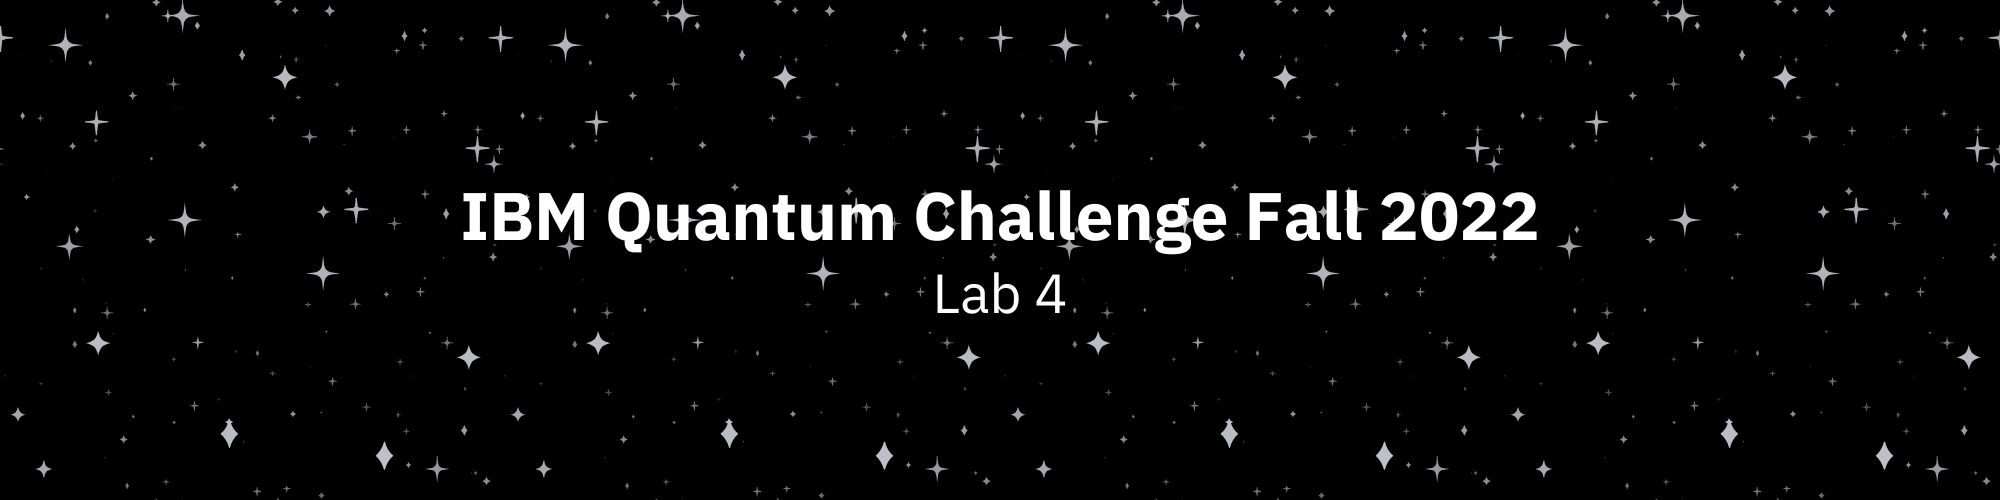

<div class="alert alert-block alert-success">
    <b> ファイナルチャレンジ（任意）のスコアリングと提出方法について </b>

- VQE　grading runを成功させるために、以下を提出してください。ノイズの多いFakeBackend上で**3回のVQE実行**を行い、算出された結果を評価します。
  - `ansatz_list` = ansatz回路のリスト
  - `ops_list` = 評価する演算子のリスト
  - `problem_reduced_list` = ElectronicStructureProblemのリスト
  - `initial_point_list`: オプティマイザの初期点のリスト (こちらはオプショナルです。このリストを渡さない場合は初期点はランダムに取得されます。)
  - `optimizer_list`:  オプティマイザーのリスト (こちらはオプショナルです。このリストを渡さない場合はデフォルト`SPSA`に設定されます。)

- 提出されたリストの順序付きインデックス:
    - **Index 0** - $C_3H_2$ (Cyclopropenylidene)
    - **Index 1** - $C$ (Carbon)
    - **Index 2** - $C_2H_2$ (Acetylene)
    
- 基準値はクラシカルコンピューターで計算し、下記に掲載しました。<br>

- スコアは、**3つの要素**によって決定されます:
    - **Depth of ansatz**: なるべく低いコストの量子回路を構築してみましょう。スコアは以下のように計算されます。低ければ低いほど良いスコアです！ <br>
    $$スコア = 50 * depth + 10 * (\text{# of CX Gates}) + \text{# of Single Gates} $$

    - **Optimizer score**: Optimizerの iteration回数
    - **Reaction Energy**: 反応エネルギーの計算値に対する収束値の近さ（単位：eV)

- **なお、チャレンジ期間終了後、審査の結果、上位のスコアが変更される場合があります。**
  - 上位10名の参加者の方には、演習をどのように解いたか、レポートを提出していただきます。 <br>
    - 審査員は上位10作品を手動でチェックし、その解答がルールに則っているかどうかを確認します。<br>
    <br>
- **また、どなたでも課題終了後、課題レポに最終問題のご自身の回答をPRいただくことができます: [htps://github.com/qiskit-community/ibm-quantum-challenge-fall-22](https://github.com/qiskit-community/ibm-quantum-challenge-fall-22)**  チャレンジレポにPRを提出する際に、 `Name_Score_Fall22_Lab4.ipynb` のフォーマットでノートブックの名前を付けて提出をしてください。

</div>


<div class="alert alert-block alert-info">
    <b>基準値</b>
    
    
- Chemistry engine: Pyscf, version 2.0.1
- Python version: 3.9.12
- Computation options used: 
    - method: CCSD
    - basis: cc-pVDZ

    
**反応エネルギーの参考値: -4.26923078561136 eV**

</div>

# Import libraries and packages

In [63]:
# Import necessary libraries and packages
import math
import matplotlib.pyplot as plt
import numpy as np

import warnings
warnings.filterwarnings('ignore')

import qiskit
from qiskit import Aer, IBMQ, QuantumCircuit
from qiskit.primitives import Estimator
from qiskit.providers.aer import StatevectorSimulator
from qiskit.utils import QuantumInstance

from qiskit.tools.jupyter import *
from qiskit.visualization import *

# Import Qiskit libraries for VQE
from qiskit.algorithms import MinimumEigensolverResult, VQE
from qiskit.algorithms.optimizers import SLSQP, SPSA, COBYLA

# Import Qiskit Nature libraries
from qiskit_nature.algorithms import GroundStateEigensolver, VQEUCCFactory
from qiskit_nature.algorithms.ground_state_solvers.minimum_eigensolver_factories import NumPyMinimumEigensolverFactory
from qiskit_nature.circuit.library import UCC, UCCSD
from qiskit_nature.drivers import Molecule
from qiskit_nature.drivers.second_quantization import ElectronicStructureDriverType, ElectronicStructureMoleculeDriver
from qiskit_nature.converters.second_quantization import QubitConverter
from qiskit_nature.mappers.second_quantization import BravyiKitaevMapper, JordanWignerMapper, ParityMapper
from qiskit_nature.problems.second_quantization.electronic import ElectronicStructureProblem
from qiskit_nature.transformers.second_quantization.electronic import ActiveSpaceTransformer

# Prototype-zne
!pip install prototype-zne --quiet

from qiskit_nature.settings import settings

settings.dict_aux_operators = True

from qiskit.primitives import Estimator, BackendEstimator
from qiskit.providers.fake_provider import FakeManilaV2, FakeAthensV2, FakeAthens, FakeLagos
from qiskit.providers.aer import AerSimulator
from qiskit.utils import algorithm_globals

In [64]:
#import Additional library
from qiskit_nature.properties.second_quantization.electronic import ParticleNumber
from qiskit_nature.circuit.library import HartreeFock


from qiskit.circuit import Parameter, QuantumCircuit
from qiskit.circuit.library import EfficientSU2, TwoLocal, NLocal, PauliTwoDesign
from qiskit_nature.circuit.library import UCCSD, PUCCD, SUCCD

from qiskit.opflow.primitive_ops import TaperedPauliSumOp,Z2Symmetries
from qiskit.quantum_info import Statevector, Pauli, SparsePauliOp

from zne import ZNEStrategy
from zne.extrapolation import PolynomialExtrapolator, LinearExtrapolator
from zne.noise_amplification import LocalFoldingAmplifier, GlobalFoldingAmplifier

# My answer

1. Firstly,I reduced qubit size of all quantum circuits for $\mathrm{C},\mathrm{C}_2\mathrm{H}_2,\mathrm{C}_3\mathrm{H}_2$ to 2 qubits using active space transformer.(Ideal VQE energies of these 2 qubits circuits are good agreement with real energies culculated by classcal computing.)

2. Then I chose Efficient SU2 for their ansatzes because it has only 1 CNOT (This gate has high error rate!) and has high ability to express 2 qubits quantum state (I believe).

3. Compare each result of sets of basis functions.Then I got best score 48183(-4.453548760637488 eV) when we use the set of basis funstions [cc-pVTZ,cc-pVTZ,3-21G] for [$\mathrm{C},\mathrm{C}_2\mathrm{H}_2,\mathrm{C}_3\mathrm{H}_2$]

4. Furthermore,changing the single gates in Efficient SU2 ansatz into U3 gates,then I got better score 27027!(This is my best score in IQC fall-2022.)

In [66]:
# Define geometry
carbon = [["C",[0.0,0.0,0.0]]]

# https://webbook.nist.gov/cgi/cbook.cgi?Name=acetylene&Units=SI
acetylene = [["C", [0.0000,    0.0000,   -0.6025]], 
            ["H",[    0.0000,    0.0000,   -1.6691]], 
            ["C",[    0.0000,    0.0000,    0.6025]], 
            ["H",[    0.0000,    0.0000,    1.6691]]]

# https://atct.anl.gov/Thermochemical%20Data/version%201.122/species/?species_number=442
Cyclopropenylidene =  [["C", [2.2883,    0.6993,    0.3468 ]],
           ["C",[    1.9543,    2.0133,    0.7806]],
           ["C",[    1.0108,    0.9522,    0.6802]],
           ["H",[    3.0291,    0.0000,    0.0000]],
           ["H",[    0.0000,    0.5997,    0.7904]]]

In [176]:
def construct_problem_mine(ansatz_type,geometry, charge, multiplicity, basis,act_list):
    molecule = Molecule(geometry=geometry,
                        charge=charge, 
                        multiplicity=multiplicity) 
    driver = ElectronicStructureMoleculeDriver(molecule, basis=basis, driver_type=ElectronicStructureDriverType.PYSCF) 
    
    ###define ElectronicStructureProblem
    #Using Active_space_transformer,we can reduce qubit size of VQE problem to 2 qubits.(you have to change the default parameters.)
    active_space_trafo = ActiveSpaceTransformer(num_electrons=act_list[0],num_molecular_orbitals=act_list[1]) 
    problem_reduced = ElectronicStructureProblem(driver, transformers=[active_space_trafo])

    #Active_space_transformer
    second_q_ops_reduced = problem_reduced.second_q_ops()
    main_op_reduced = second_q_ops_reduced['ParticleNumber']

    ###Get_PauliStrings_Hamiltonian
    num_particles_reduced = problem_reduced.num_particles
    converter_reduced = QubitConverter(ParityMapper(), two_qubit_reduction=True)
    qubit_op_reduced = converter_reduced.convert(second_q_ops_reduced.get('ElectronicEnergy'),problem_reduced.num_particles)
    
    
    init_state_reduced = HartreeFock(problem_reduced.num_spin_orbitals, problem_reduced.num_particles, converter_reduced)
    
    #choose ansatz you use(I used Efficient SU2 ansatz.)
    if ansatz_type=='Custum_UCCSD':
        num_qubits = qubit_op_reduced.num_qubits
        param_count = 1
        theta = Parameter(f"rz_angle{param_count}" )
        qc = QuantumCircuit(num_qubits)
        qc.rx(-np.pi/2,0)
        qc.ry(np.pi/2,1)
        qc.cx(1,0)
        qc.rz(theta,0)
        qc.cx(1,0)
        qc.rx(np.pi/2,0)
        qc.ry(-np.pi/2,1)
        
        ansatz = qc
        ansatz.compose(init_state_reduced, front=True, inplace=True)
    
    else:
        ansatz = EfficientSU2(num_qubits=qubit_op_reduced.num_qubits,
                              reps=1,
                              entanglement='linear',
                              initial_state=init_state_reduced,
                              insert_barriers=True)
        
    print(ansatz.decompose())
    return ansatz, qubit_op_reduced, problem_reduced

In [177]:
#substitute act_list into [2,2] to reduce qubit size to2 qubit using active space transformer.
#Culculate again and again with changing set of basis function to choose the best set.
"""
ansatz_c, ops_c, problem_reduced_c = construct_problem_mine('Effi_SU2',geometry=carbon, charge=0, multiplicity=3, basis="ccpvdz",act_list=[2,2])
ansatz_ac, ops_ac, problem_reduced_ac = construct_problem_mine('Effi_SU2',geometry=acetylene, charge=0, multiplicity=1, basis="ccpvdz",act_list=[2,2])
ansatz_cy, ops_cy, problem_reduced_cy = construct_problem_mine('Effi_SU2',geometry=Cyclopropenylidene, charge=0, multiplicity=1, basis="sto3g",act_list=[2,2])
"""
ansatz_c, ops_c, problem_reduced_c = construct_problem_mine('Effi_SU2',geometry=carbon, charge=0, multiplicity=3, basis="ccpvtz",act_list=[2,2])
ansatz_ac, ops_ac, problem_reduced_ac = construct_problem_mine('Effi_SU2',geometry=acetylene, charge=0, multiplicity=1, basis="ccpvtz",act_list=[2,2])
ansatz_cy, ops_cy, problem_reduced_cy = construct_problem_mine('Effi_SU2',geometry=Cyclopropenylidene, charge=0, multiplicity=1, basis="321g",act_list=[2,2])
print(ops_c,ops_ac,ops_cy)

        ┌───┐    ┌──────────┐┌──────────┐ ░       ░ ┌──────────┐┌──────────┐
q_0: ───┤ X ├────┤ Ry(θ[0]) ├┤ Rz(θ[2]) ├─░───■───░─┤ Ry(θ[4]) ├┤ Rz(θ[6]) ├
     ┌──┴───┴───┐├──────────┤└──────────┘ ░ ┌─┴─┐ ░ ├──────────┤├──────────┤
q_1: ┤ Ry(θ[1]) ├┤ Rz(θ[3]) ├─────────────░─┤ X ├─░─┤ Ry(θ[5]) ├┤ Rz(θ[7]) ├
     └──────────┘└──────────┘             ░ └───┘ ░ └──────────┘└──────────┘
        ┌───┐    ┌──────────┐┌──────────┐ ░       ░ ┌──────────┐┌──────────┐
q_0: ───┤ X ├────┤ Ry(θ[0]) ├┤ Rz(θ[2]) ├─░───■───░─┤ Ry(θ[4]) ├┤ Rz(θ[6]) ├
     ┌──┴───┴───┐├──────────┤└──────────┘ ░ ┌─┴─┐ ░ ├──────────┤├──────────┤
q_1: ┤ Ry(θ[1]) ├┤ Rz(θ[3]) ├─────────────░─┤ X ├─░─┤ Ry(θ[5]) ├┤ Rz(θ[7]) ├
     └──────────┘└──────────┘             ░ └───┘ ░ └──────────┘└──────────┘
        ┌───┐    ┌──────────┐┌──────────┐ ░       ░ ┌──────────┐┌──────────┐
q_0: ───┤ X ├────┤ Ry(θ[0]) ├┤ Rz(θ[2]) ├─░───■───░─┤ Ry(θ[4]) ├┤ Rz(θ[6]) ├
     ┌──┴───┴───┐├──────────┤└──────────┘ ░ ┌─┴─┐ ░ ├──────────┤├──────────┤

In [134]:
ansatz_list = [ansatz_cy, ansatz_c, ansatz_ac] # List of ansatz circuits
ops_list = [ops_cy, ops_c, ops_ac] # List of operators
problem_reduced_list = [problem_reduced_cy,  problem_reduced_c,  problem_reduced_ac] # List of ElectronicStrucutreProblem
#initial_point_list = [list(2*np.pi*np.random.rand(8)-np.pi),list(2*np.pi*np.random.rand(8)-np.pi),list(2*np.pi*np.random.rand(8)-np.pi)]
initial_point_list = [[-0.0153804 ,  0.807453  , -0.15305281,  0.46587973, -0.28819403,0.5077208 , -0.08486129,  0.47760656]
                     ,[-0.15643632,  0.36711215,  0.28728804, -0.17895308,  1.42626398,-0.70296032, -0.7296941 ,  1.10689091]
                     ,[ 1.28575535, -0.49368276,  1.14808294, -0.17346721, -0.42376408,-0.69747444,  0.71249757, -0.16174038]]
optimizer_list = [SPSA(maxiter=1),SPSA(maxiter=1),SPSA(maxiter=1)]
print(initial_point_list)

[[-0.0153804, 0.807453, -0.15305281, 0.46587973, -0.28819403, 0.5077208, -0.08486129, 0.47760656], [-0.15643632, 0.36711215, 0.28728804, -0.17895308, 1.42626398, -0.70296032, -0.7296941, 1.10689091], [1.28575535, -0.49368276, 1.14808294, -0.17346721, -0.42376408, -0.69747444, 0.71249757, -0.16174038]]


In [121]:
###I didn't use ZNE
# Define Extrapolator
extrapolator = PolynomialExtrapolator(degree=2)
# Define Amplifier
noise_amplifier = LocalFoldingAmplifier(gates_to_fold=2)

# Define strategy
zne_strategy = ZNEStrategy(
    noise_factors=[1.0,2.0,3.0],
    noise_amplifier = noise_amplifier,
    extrapolator=extrapolator
)

In [135]:
## Grade and submit your solution
from qc_grader.challenges.fall_2022 import grade_lab4_final
#grade_lab4_final(ansatz_list,} ops_list, problem_reduced_list)
grade_lab4_final(ansatz_list, ops_list, problem_reduced_list,initial_point_list,optimizer_list)
#grade_lab4_final(ansatz_list, ops_list, problem_reduced_list, initial_point_list, optimizer_list, zne_strategy)

Running VQE....... 1
VQE run 1 complete
Converged value for run 1 is: (-113.78588708566483+0j)
Result for run 1: {   'fun': -1.0600476824536968,
    'jac': None,
    'nfev': 2,
    'nit': 1,
    'njev': None,
    'x': array([-0.720559  ,  1.5126316 , -0.85823141,  1.17105833,  0.41698457,
       -0.1974578 , -0.79003989,  1.18278516])} 

Running VQE....... 2
VQE run 2 complete
Converged value for run 2 is: (-37.29520426264701+0j)
Result for run 2: {   'fun': -0.9640100533741784,
    'jac': None,
    'nfev': 2,
    'nit': 1,
    'njev': None,
    'x': array([-1.05707876, -0.53353029,  1.18793048,  0.72168936,  2.32690642,
       -1.60360276, -1.63033654,  2.00753335])} 

Running VQE....... 3
VQE run 3 complete
Converged value for run 3 is: (-76.24060440829021+0j)
Result for run 3: {   'fun': -0.6836696742808179,
    'jac': None,
    'nfev': 2,
    'nit': 1,
    'njev': None,
    'x': array([ 0.34320137,  0.44887122,  2.09063692, -1.11602119, -1.36631806,
        0.24507954,  1.65505155,

In [ ]:
#####Results of each set of basis functions#####
###set of basis functions(C,C2H2,C3H2):score
###ccpvdz,ccpvdz,,sto3g:52898
#[-0.04715006, -0.79771876,  1.45211894, -0.06966682, -0.31996369,1.04326735, -0.62040784,  1.57900142]
#[ 0.4843934 , -0.26617529,  0.92057548,  1.03573112,  0.78543425,-0.0621306 ,  0.48499011,  1.04745795]
#[ 1.87147165, -1.07939906, -0.46650277, -0.35134712, -0.60164399,-0.87535436, -0.90208814,  1.86068172]
###augccpvdz,augccpvdz,321g:74700
#[ 1.19805871,  0.44749002,  0.20691016,  0.32206581,  0.07176894,-0.20194142, -0.22867521,  0.33379264]
#[0.64300215, 0.14907045, 0.76196673, 0.87712238, 0.37018852,0.35311514, 0.32638136, 0.63221222]
#[ 0.56395911,  0.22811348,  0.4262867 ,  0.95616541,  0.29114548,0.01743511, -0.00929867,  0.96789224]
###ccpvtz,ccpvtz,321g:69134
#[ 0.5194322 ,  0.2726404 ,  0.38175979,  1.00069233,  0.24661857,-0.0270918 ,  0.44995131,  1.01241916]
#[ 0.48062226, -0.26994643,  0.92434662,  0.4581055 ,  0.7892054 ,-0.06590174, -0.09263552,  0.46983233]
#[ 0.56740245,  0.22467014,  0.42973004,  0.54488569,  0.29458882,0.02087846, -0.00585533,  0.55661252]
#ccpvtz,ccpvtz,321g:64000
#[-0.69528424,  1.48735684,  1.59647623,  2.21540877, -0.96809787,-1.24180824,  1.66466775,  2.2271356 ]
#[-0.03248142, -0.78305011,  1.4374503 ,  0.97120918,  1.30230908,-0.57900542, -0.6057392 ,  0.98293601]
#[ 1.13159834,  0.78886603, -0.13446585,  1.10908158, -0.26960707,0.58507435,  0.55834056,  1.12080841]
#ccpvtz,ccpvtz,321g:48639(-3.56986508650286 eV)←best score!!
#[-0.0153804 ,  0.807453  , -0.15305281,  0.46587973, -0.28819403,0.5077208 , -0.08486129,  0.47760656]
#[-0.15643632,  0.36711215,  0.28728804, -0.17895308,  1.42626398,-0.70296032, -0.7296941 ,  1.10689091]
#[ 1.28575535, -0.49368276,  1.14808294, -0.17346721, -0.42376408,-0.69747444,  0.71249757, -0.16174038]
#ccpvtz,ccpvtz,321g:50326(-2.7939513314371123 eV)
#[-0.08418676,  0.87625936,  0.98537875,  1.60431129, -0.35700039,0.57652716,  1.05357027,  0.4088002 ]
#[-0.44983028,  0.66050611,  1.85479916,  1.38855804,  1.71965794,0.8645508 , -1.02308806,  1.40028487]
#[ 0.73567408,  0.05639851,  0.59800167,  0.37661406,  0.12631719,0.18915009, -0.17412696,  0.38834089]
#ccpvtz,ccpvtz,321g:48920(-3.3914010054444264 eV)
#[-0.47662524, -0.72341704, -0.61429765,  0.00463489, -0.74943887,-1.02314924, -0.54610613,  0.01636172]
#[-0.66147752,  0.87215335, -0.21775316, -0.68399428,  1.93130518,1.07619804, -1.2347353 , -0.67226745]
#[ 1.42247076,  1.07973845,  1.28479835,  1.399954  , -0.56047949,-0.83418985,  0.84921298, -0.29845579]
###ccpvtz,ccpvtz,631g:302871
###ccpvtz,ccpvtz,sto3g:77124
#[ 1.72447222, -0.93239963, -0.31950335, -0.2043477 , -0.45464457,-0.72835494,  1.15121445, -0.19262087]
#[ 1.76979607, -0.97772348, -0.36482719,  1.74727931,  1.49698244,1.22327207, -0.80041256, -0.23794472]
#[-0.14932442, -0.89989312, -0.28699683,  1.66944895, -0.42213806,1.14544171,  1.11870793,  1.68117578]

### Changing the single gates in Efficient SU2 ansatz into U3 gates

In [207]:
def from_init_Effi_SU2(init_list):
    #Efficient SU2 ansatz
    ansatz_trial = QuantumCircuit(2)
    ansatz_trial.x(0)
    theta_ry = [Parameter(f"ry_angle{i}") for i in range(4)]
    theta_rz = [Parameter(f"rz_angle{i}") for i in range(4)]
    ansatz_trial.ry(theta_ry[0],0)
    ansatz_trial.rz(theta_rz[0],0)
    ansatz_trial.ry(theta_ry[1],1)
    ansatz_trial.rz(theta_rz[1],1)
    ansatz_trial.barrier()
    ansatz_trial.cx(0,1)
    ansatz_trial.barrier()
    ansatz_trial.ry(theta_ry[2],0)
    ansatz_trial.rz(theta_rz[2],0)
    ansatz_trial.ry(theta_ry[3],1)
    ansatz_trial.rz(theta_rz[3],1)
    
    #substitute the best initial_parameters() into each parameters of Efficient SU2 ansatz
    ansatz_trial = ansatz_trial.bind_parameters({theta_ry[0]:init_list[0],theta_rz[0]:init_list[2],
                                                 theta_ry[1]:init_list[1],theta_rz[1]:init_list[3],
                                                 theta_ry[2]:init_list[4],theta_rz[2]:init_list[6],
                                                 theta_ry[3]:init_list[5],theta_rz[3]:init_list[7]})
    
    #rewrite Efficient SU2 ansatz (inputted the best initial parameters) using U3 gate.
    ansatz_reduced = qiskit.compiler.transpile(ansatz_trial,basis_gates=['id','u1','u2','u3','cx'])
    #print the best initial parameters for new circuit
    print(ansatz_reduced.data)
    
    #new circuit
    ansatz_use = QuantumCircuit(2)
    string = ['a','b','c','d','e','f','g','h','i','j','k','l']
    params = [Parameter(f"param_{string[i]}") for i in range(12)]
    ansatz_use.u3(params[0],params[1],params[2],0)
    ansatz_use.u3(params[3],params[4],params[5],1)
    ansatz_use.barrier()
    ansatz_use.cx(0,1)
    ansatz_use.barrier()
    ansatz_use.u3(params[6],params[7],params[8],0)
    ansatz_use.u3(params[9],params[10],params[11],1)
    return ansatz_use

In [208]:
#use the best set of basis functions (ccpvtz,ccpvtz,321g) for (C,C2H2,C3H2)
ansatz_c, ops_c, problem_reduced_c = construct_problem_mine('Effi_SU2',geometry=carbon, charge=0, multiplicity=3, basis="ccpvtz",act_list=[2,2])
ansatz_ac, ops_ac, problem_reduced_ac = construct_problem_mine('Effi_SU2',geometry=acetylene, charge=0, multiplicity=1, basis="ccpvtz",act_list=[2,2])
ansatz_cy, ops_cy, problem_reduced_cy = construct_problem_mine('Effi_SU2',geometry=Cyclopropenylidene, charge=0, multiplicity=1, basis="321g",act_list=[2,2])
print(ops_c,ops_ac,ops_cy)

        ┌───┐    ┌──────────┐┌──────────┐ ░       ░ ┌──────────┐┌──────────┐
q_0: ───┤ X ├────┤ Ry(θ[0]) ├┤ Rz(θ[2]) ├─░───■───░─┤ Ry(θ[4]) ├┤ Rz(θ[6]) ├
     ┌──┴───┴───┐├──────────┤└──────────┘ ░ ┌─┴─┐ ░ ├──────────┤├──────────┤
q_1: ┤ Ry(θ[1]) ├┤ Rz(θ[3]) ├─────────────░─┤ X ├─░─┤ Ry(θ[5]) ├┤ Rz(θ[7]) ├
     └──────────┘└──────────┘             ░ └───┘ ░ └──────────┘└──────────┘
        ┌───┐    ┌──────────┐┌──────────┐ ░       ░ ┌──────────┐┌──────────┐
q_0: ───┤ X ├────┤ Ry(θ[0]) ├┤ Rz(θ[2]) ├─░───■───░─┤ Ry(θ[4]) ├┤ Rz(θ[6]) ├
     ┌──┴───┴───┐├──────────┤└──────────┘ ░ ┌─┴─┐ ░ ├──────────┤├──────────┤
q_1: ┤ Ry(θ[1]) ├┤ Rz(θ[3]) ├─────────────░─┤ X ├─░─┤ Ry(θ[5]) ├┤ Rz(θ[7]) ├
     └──────────┘└──────────┘             ░ └───┘ ░ └──────────┘└──────────┘
        ┌───┐    ┌──────────┐┌──────────┐ ░       ░ ┌──────────┐┌──────────┐
q_0: ───┤ X ├────┤ Ry(θ[0]) ├┤ Rz(θ[2]) ├─░───■───░─┤ Ry(θ[4]) ├┤ Rz(θ[6]) ├
     ┌──┴───┴───┐├──────────┤└──────────┘ ░ ┌─┴─┐ ░ ├──────────┤├──────────┤

In [209]:
#the best initial paramters(ccpvtz,ccpvtz,321g:48639(-3.56986508650286 eV))
init_list = [[-0.0153804 ,  0.807453  , -0.15305281,  0.46587973, -0.28819403,0.5077208 , -0.08486129,  0.47760656]
            ,[-0.15643632,  0.36711215,  0.28728804, -0.17895308,  1.42626398,-0.70296032, -0.7296941 ,  1.10689091]
            ,[ 1.28575535, -0.49368276,  1.14808294, -0.17346721, -0.42376408,-0.69747444,  0.71249757, -0.16174038]]
ansatz_c = from_init_Effi_SU2(init_list[0])
ansatz_ac = from_init_Effi_SU2(init_list[1])
ansatz_cy = from_init_Effi_SU2(init_list[2])

[CircuitInstruction(operation=Instruction(name='u3', num_qubits=1, num_clbits=0, params=[3.126212253589793, -0.15305280999999926, -3.141592653589793]), qubits=(Qubit(QuantumRegister(2, 'q'), 0),), clbits=()), CircuitInstruction(operation=Instruction(name='u3', num_qubits=1, num_clbits=0, params=[0.807453, 0.46587973000000016, 0.0]), qubits=(Qubit(QuantumRegister(2, 'q'), 1),), clbits=()), CircuitInstruction(operation=Instruction(name='barrier', num_qubits=2, num_clbits=0, params=[]), qubits=(Qubit(QuantumRegister(2, 'q'), 0), Qubit(QuantumRegister(2, 'q'), 1)), clbits=()), CircuitInstruction(operation=Instruction(name='cx', num_qubits=2, num_clbits=0, params=[]), qubits=(Qubit(QuantumRegister(2, 'q'), 0), Qubit(QuantumRegister(2, 'q'), 1)), clbits=()), CircuitInstruction(operation=Instruction(name='barrier', num_qubits=2, num_clbits=0, params=[]), qubits=(Qubit(QuantumRegister(2, 'q'), 0), Qubit(QuantumRegister(2, 'q'), 1)), clbits=()), CircuitInstruction(operation=Instruction(name='u3

In [210]:
ansatz_c.parameters

ParameterView([Parameter(param_a), Parameter(param_b), Parameter(param_c), Parameter(param_d), Parameter(param_e), Parameter(param_f), Parameter(param_g), Parameter(param_h), Parameter(param_i), Parameter(param_j), Parameter(param_k), Parameter(param_l)])

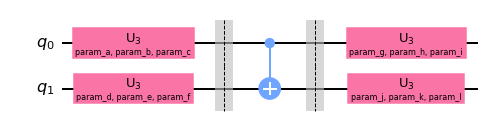

In [211]:
ansatz_c.draw()

In [213]:
#define the best initial paramter list (for new circuits) from results above.
initial_point_list = [[3.126212253589793, -0.15305280999999926, -3.141592653589793,0.807453, 0.46587973000000016, 0.0
                    ,0.28819403, 3.056731363589793, -3.141592653589793,0.5077208000000001, 0.4776065599999999, 0.0],
                   [2.985156333589793, 0.28728803999999997, -3.141592653589793,0.3671121499999999, -0.17895307999999988, 0.0
                    ,1.4262639800000005, -0.7296941000000001, 0.0,0.7029603200000003, -2.0347017435897934, -3.141592653589793],
                   [1.855837303589793, -1.993509713589793, 0.0,0.49368276, 2.968125443589793, -3.141592653589793
                   ,0.4237640799999999, -2.429095083589793, -3.141592653589793,0.6974744400000004, 2.9798522735897937, -3.141592653589793]]

In [214]:
ansatz_list = [ansatz_cy, ansatz_c, ansatz_ac] # List of ansatz circuits
ops_list = [ops_cy, ops_c, ops_ac] # List of operators
problem_reduced_list = [problem_reduced_cy,  problem_reduced_c,  problem_reduced_ac] # List of ElectronicStrucutreProblem
optimizer_list = [SPSA(maxiter=0),SPSA(maxiter=0),SPSA(maxiter=0)]
"""
###I didn't use ZNE
# Define Extrapolator
extrapolator = PolynomialExtrapolator(degree=2)
# Define Amplifier
noise_amplifier = LocalFoldingAmplifier(gates_to_fold=2)

# Define strategy
zne_strategy = ZNEStrategy(
    noise_factors=[1.0,2.0,3.0],
    noise_amplifier = noise_amplifier,
    extrapolator=extrapolator
)
"""
print(initial_point_list)

[[3.126212253589793, -0.15305280999999926, -3.141592653589793, 0.807453, 0.46587973000000016, 0.0, 0.28819403, 3.056731363589793, -3.141592653589793, 0.5077208000000001, 0.4776065599999999, 0.0], [2.985156333589793, 0.28728803999999997, -3.141592653589793, 0.3671121499999999, -0.17895307999999988, 0.0, 1.4262639800000005, -0.7296941000000001, 0.0, 0.7029603200000003, -2.0347017435897934, -3.141592653589793], [1.855837303589793, -1.993509713589793, 0.0, 0.49368276, 2.968125443589793, -3.141592653589793, 0.4237640799999999, -2.429095083589793, -3.141592653589793, 0.6974744400000004, 2.9798522735897937, -3.141592653589793]]


In [215]:
## Grade and submit your solution
from qc_grader.challenges.fall_2022 import grade_lab4_final
#grade_lab4_final(ansatz_list,} ops_list, problem_reduced_list)
grade_lab4_final(ansatz_list, ops_list, problem_reduced_list,initial_point_list,optimizer_list)
#grade_lab4_final(ansatz_list, ops_list, problem_reduced_list, initial_point_list, optimizer_list, zne_strategy)

Running VQE....... 1
VQE run 1 complete
Converged value for run 1 is: (-113.73228854518106+0j)
Result for run 1: {   'fun': -1.0064491419698456,
    'jac': None,
    'nfev': 13,
    'nit': 1,
    'njev': 1,
    'x': array([ 3.12621225, -0.15305281, -3.14159265,  0.807453  ,  0.46587973,
        0.        ,  0.28819403,  3.05673136, -3.14159265,  0.5077208 ,
        0.47760656,  0.        ])} 

Running VQE....... 2
VQE run 2 complete
Converged value for run 2 is: (-37.224336350548526+0j)
Result for run 2: {   'fun': -0.8931421412757112,
    'jac': None,
    'nfev': 13,
    'nit': 1,
    'njev': 1,
    'x': array([ 2.98515633,  0.28728804, -3.14159265,  0.36711215, -0.17895308,
        0.        ,  1.42626398, -0.7296941 ,  0.        ,  0.70296032,
       -2.03470174, -3.14159265])} 

Running VQE....... 3
VQE run 3 complete
Converged value for run 3 is: (-76.37645897485828+0j)
Result for run 3: {   'fun': -0.8195242408487955,
    'jac': None,
    'nfev': 13,
    'nit': 1,
    'njev': 1,


### This is my best score in IQC fall-2022!

In [ ]:
from qiskit.tools.jupyter import *
%qiskit_version_table